In [39]:
import numpy as np
import seaborn as sns
import pandas as pd

import matplotlib.pyplot as plt

import keijzer_exogan as ke

from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm
from glob import glob

from sklearn.metrics import r2_score
from scipy import stats

%matplotlib inline
%config InlineBackend.print_figure_kwargs={'facecolor' : "w"} # Make sure the axis background of plots is white, this is usefull for the black theme in JupyterLab

# Initialize default seaborn layout
sns.set_palette(sns.hls_palette(8, l=.3, s=.8))
sns.set(style='ticks') 

# load inpainting data from the inpainting notebook(s)

In [40]:
# debug_0_5000_1_1e-1_c , Same inpainting settings as ExoGAN

general_name = 'debug_0_1000_1e-1_5_wgan_simple' # general filename, e.g. 'test' for test_reals.npy, test_inpainteds.npy... etc.

# get the file paths of the result files
reals = glob('gan_data//val_errors//'+general_name+'_reals.npy')
inpainteds = glob('gan_data//val_errors//'+general_name+'_inpainteds.npy')
n_iterations = glob('gan_data//val_errors//'+general_name+'_n_iterations.npy')


contextuals = glob('gan_data//val_errors//'+general_name+'_contextual_losses.npy')
perceptuals = glob('gan_data//val_errors//'+general_name+'_perceptual_losses.npy')

reals

['gan_data//val_errors//debug_0_1000_1e-1_5_wgan_simple_reals.npy']

In [41]:
# load arrays to list, convert list to ndarray with shape (aspa, n_inpaintings, height, width)
reals = np.concatenate([np.load(path) for path in reals], axis=0)
inpainteds = np.concatenate([np.load(path) for path in inpainteds], axis=0)

perceptuals = np.concatenate([np.load(path) for path in perceptuals], axis=0)
contextuals = np.concatenate([np.load(path) for path in contextuals], axis=0)

# take mean of the n_inpaintings per aspa
n_aspas = reals.shape[0]
reals = reals.mean(axis=1).reshape(n_aspas,1,32,32)
inpainteds = inpainteds.mean(axis=1).reshape(n_aspas,1,32,32)

In [42]:
reals.shape

(1000, 1, 32, 32)

In [43]:
reals.mean(1).shape

(1000, 32, 32)

# Error of ASPA $i$

In [44]:
"""
3739 is bad with errors: -20.025595	-59.902499	831.523538	-28.148670	22.250920	0.759872	-8.532101 (831% is CO)
4788 is good with errors: 4.121214	0.958426	0.045486	0.866588	-5.077431	-0.756804	2.978271
4998 is 'decent' with errors: 5.578141	7.753601	-6.975316	5.797133	39.391482	-1.526314	-41.867831
"""
i = 0 

decodeds =[ke.decode_params_from_aspa(inpainteds[i, j]) for j in range(reals.shape[1])]

df = pd.DataFrame.from_dict(decodeds)
df['perceptuals'] = pd.DataFrame(perceptuals)
df['contextuals'] = pd.DataFrame(contextuals)

df.describe()

,ch4_mixratio,co2_mixratio,co_mixratio,h2o_mixratio,planet_mass,planet_radius,temp_profile,perceptuals,contextuals
count,1.000000,1.000000,1.000000,1.000000,1.000000e+00,1.000000e+00,1.000000,1.000000,1.00000
mean,-5.317483,-1.568534,-2.829536,-5.899393,2.483970e+27,7.633763e+07,1638.587564,-0.089878,13.08766
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,-5.317483,-1.568534,-2.829536,-5.899393,2.483970e+27,7.633763e+07,1638.587564,-0.089878,13.08766
25%,-5.317483,-1.568534,-2.829536,-5.899393,2.483970e+27,7.633763e+07,1638.587564,-0.089878,13.08766
50%,-5.317483,-1.568534,-2.829536,-5.899393,2.483970e+27,7.633763e+07,1638.587564,-0.089878,13.08766
75%,-5.317483,-1.568534,-2.829536,-5.899393,2.483970e+27,7.633763e+07,1638.587564,-0.089878,13.08766
max,-5.317483,-1.568534,-2.829536,-5.899393,2.483970e+27,7.633763e+07,1638.587564,-0.089878,13.08766


In [45]:
df

,ch4_mixratio,co2_mixratio,co_mixratio,h2o_mixratio,planet_mass,planet_radius,temp_profile,perceptuals,contextuals
0,-5.317483,-1.568534,-2.829536,-5.899393,2.483970e+27,7.633763e+07,1638.587564,-0.089878,13.08766


In [46]:
if reals.shape[1] > 1 :
    params = ['planet_mass','ch4_mixratio','planet_radius','h2o_mixratio','co2_mixratio','co_mixratio']

    fontsize = 16
    plt.figure(figsize=((25,10)))
    for i,param in enumerate(params):
        plt.subplot(3,3,i+1)
        plt.title(param, fontsize=fontsize)
        plt.hist(df[param], bins=25)

        # plot mean and median line
        mu = df[param].mean()
        plt.axvline(x=mu,  color='black', linestyle='-.', alpha=0.9, label='mean')
        plt.axvline(x=df[param].median(),  color='black', linestyle='-', alpha=1, label='median')

        # plot std lines
        plt.axvline(x=mu-df[param].std(),  color='black', linestyle=':', alpha=1, label=r'$\sigma$')
        plt.axvline(x=mu+df[param].std(),  color='black', linestyle=':', alpha=1)

        plt.xticks(fontsize=fontsize)
        plt.yticks(fontsize=fontsize)

        plt.xlabel('Percentage error [%]', fontsize=fontsize)
        plt.ylabel('Counts [-]', fontsize=fontsize)

        plt.legend(fontsize=fontsize)
        plt.grid()
        plt.tight_layout()

In [47]:
reals.shape

(1000, 1, 32, 32)

In [48]:
#reals = reals.mean(axis=1) # take the mean of n_inpaintings per aspa, new shape is (aspa, height, width)
#inpainteds = inpainteds.mean(axis=1)

#reals = reals.reshape(reals.shape[0]*reals.shape[1], 32,32)
#inpainteds = inpainteds.reshape(inpainteds.shape[0]*inpainteds.shape[1], 32,32)

#from scipy import stats
#df = df[(np.abs(stats.zscore(df)) < 1).all(axis=1)]

reals.shape

(1000, 1, 32, 32)

In [49]:
reals.shape

(1000, 1, 32, 32)

## Spectrum plot

In [50]:
real = reals[i][0]
inpainted = inpainteds[i][0]

real.shape, inpainted.shape

((32, 32), (32, 32))

In [51]:
real_spec = real[:16, :25].flatten()
inpainted_spec = inpainted[:16, :25].flatten()

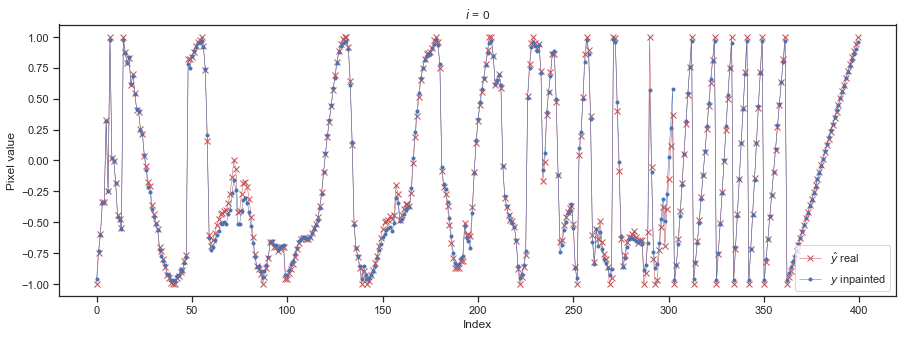

In [52]:
# :16, :25 is the spectrum location within the ASPA
plt.figure(figsize=(15,5))
plt.plot(real_spec, 'x-', c='r', linewidth=0.5, label=r'$\hat{y}$ real')
plt.plot(inpainted_spec, '.-', linewidth=0.5, label=r'$y$ inpainted')

plt.title(r'$i$ = %s' % i)
plt.xlabel('Index')
plt.ylabel('Pixel value')
plt.legend()

# Pixel difference plot

Text(0,0.5,'$y$-$\\hat{y}$')

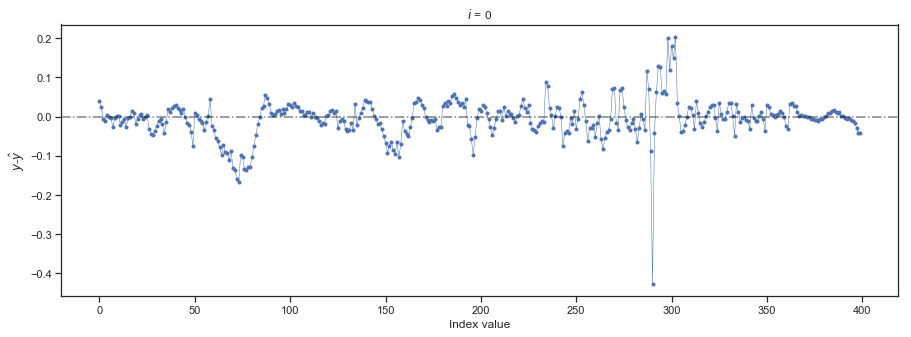

In [53]:
plt.figure(figsize=(15,5))

plt.plot(inpainted_spec - real_spec, '.-', linewidth=0.5)

plt.axhline(y=0,  color='black', linestyle='-.', alpha=0.5)

plt.title(r'$i$ = %s' % i)
plt.xlabel('Index value')
plt.ylabel(r'$y$-$\hat{y}$')

/home/16011015/notebooks/SRON-DCGAN/notebooks/keijzer_exogan.py:375: RuntimeWarning: Mean of empty slice.
  mins_ = [aspa[16:17, i*2:i*2+2].mean() for i in range(n_bins)]
/opt/jupyterhub/anaconda/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)
/home/16011015/notebooks/SRON-DCGAN/notebooks/keijzer_exogan.py:376: RuntimeWarning: Mean of empty slice.
  maxs_ = [aspa[17:18, i*2:i*2+2].mean() for i in range(n_bins)]
/opt/jupyterhub/anaconda/lib/python3.6/site-packages/pandas/core/generic.py:5096: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


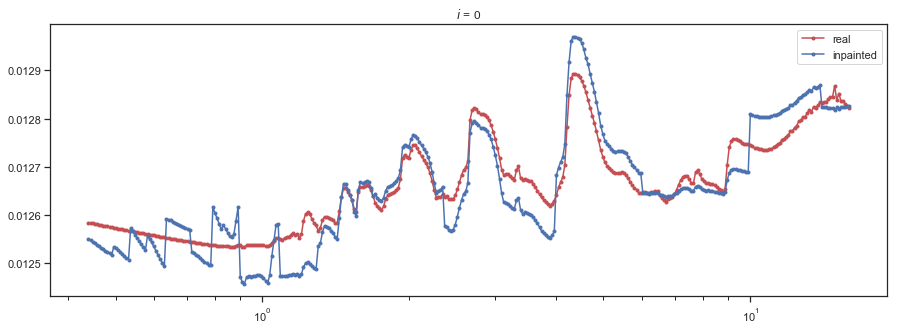

In [54]:
xhat,yhat = ke.decode_spectrum_from_aspa(real)
x,y  = ke.decode_spectrum_from_aspa(inpainted)

plt.figure(figsize=(15,5))
plt.plot(xhat, yhat, '.-', label='real', c='r')
plt.plot(x,y,'.-', label='inpainted')

plt.gca().set_xscale('log')

plt.title(r'$i$ = %s' % i)
plt.legend()

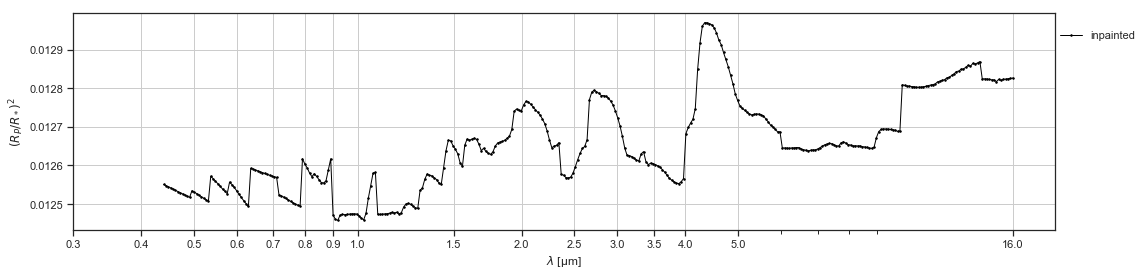

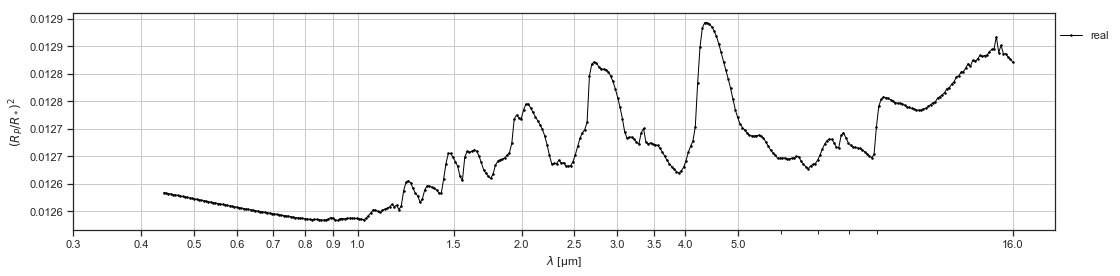

In [55]:
ke.plot_trans(x,y, label='inpainted')
ke.plot_trans(xhat,yhat, label='real')

# Error of all ASPAs

In [56]:
reals.shape

(1000, 1, 32, 32)

In [57]:
reals = [ke.decode_params_from_aspa(real[0]) for real in reals]
inpainteds = [ke.decode_params_from_aspa(inpainted[0]) for inpainted in inpainteds]

In [58]:
# create dfs for real, inpainted and their percentage errors

reals = pd.DataFrame.from_dict(reals)
inpainteds = pd.DataFrame.from_dict(inpainteds)
errors = (inpainteds - reals) / reals * 100

In [59]:
contextuals.shape

(1000,)

In [60]:
errors = errors.replace([np.inf, -np.inf], np.nan) # TODO: Fix the occurance of inf, this has to do with 0 Kelvin values

reals.columns = [column+'_real' for column in reals.columns]
inpainteds.columns = [column+'_inpainted' for column in inpainteds.columns]
errors.columns = [column+'_error' for column in errors.columns]

## Errors df

In [61]:
errors.describe()

,ch4_mixratio_error,co2_mixratio_error,co_mixratio_error,h2o_mixratio_error,planet_mass_error,planet_radius_error,temp_profile_error
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,12.867184,2.261045,8.582693,0.989271,8.829395,-0.342836,4.190583
std,30.480546,16.450892,46.692380,11.103012,33.635777,0.960218,27.913997
min,-59.479269,-37.044325,-80.571938,-34.544149,-58.152891,-3.272891,-49.905902
25%,-1.551883,-5.067411,-14.461292,-4.483268,-16.375438,-1.021776,-16.916480
50%,3.292881,-0.719453,1.706215,-1.037650,2.756475,-0.403634,1.158102
75%,18.969595,5.664679,19.311301,5.427186,28.222364,0.266130,21.902967
max,262.236434,184.176841,433.472653,66.615134,125.118278,3.751073,91.453314


In [62]:
errors[:10]

,ch4_mixratio_error,co2_mixratio_error,co_mixratio_error,h2o_mixratio_error,planet_mass_error,planet_radius_error,temp_profile_error
0,8.766704,-11.769974,-31.173448,4.106939,-34.563488,-1.726673,63.858756
1,0.717195,-0.210134,41.062564,-9.130062,-21.340510,-0.887254,1.154599
2,1.463096,6.761801,8.403686,-3.953620,-12.846145,-0.509056,-15.411837
3,-0.217243,-3.263276,7.913322,3.395967,15.789544,0.438018,11.602601
4,-0.242970,3.293598,22.394414,0.012245,16.705932,-1.036291,2.564658
5,106.798235,19.545631,-20.462521,21.068250,-20.494529,-0.437342,31.027780
6,154.323396,-13.363746,6.800699,-7.770824,67.674142,0.108782,26.442625
7,-2.212862,-14.383760,-13.694553,-5.200030,97.475691,0.755140,40.292646
8,1.793681,1.859358,19.527265,5.805396,103.720611,-2.228422,16.615897
9,-1.334638,1.591807,-10.290766,-6.859646,-4.812124,0.119070,19.951828


In [63]:
errors[(errors.co_mixratio_error < 0.1) & (errors.co_mixratio_error > -0.1)]

,ch4_mixratio_error,co2_mixratio_error,co_mixratio_error,h2o_mixratio_error,planet_mass_error,planet_radius_error,temp_profile_error
312,4.760952,-4.690703,-0.075624,-8.577211,-16.677259,-0.607254,50.730348
413,3.514577,-3.958992,-0.097811,14.051666,64.058660,-0.505276,-23.664010
782,4.469261,-0.820213,0.004694,-0.970424,-2.095683,0.095840,-13.066205
830,-3.459170,-3.785010,0.084846,-2.176781,58.835104,-0.944195,29.341197


In [64]:
### join the dfs together
df = reals.join(inpainteds, how='outer')
df = df.join(errors, how='outer')

df['perceptuals'] = pd.DataFrame(perceptuals)
df['contextuals'] = pd.DataFrame(contextuals)

In [65]:
df.describe()

,ch4_mixratio_real,co2_mixratio_real,co_mixratio_real,h2o_mixratio_real,planet_mass_real,planet_radius_real,temp_profile_real,ch4_mixratio_inpainted,co2_mixratio_inpainted,co_mixratio_inpainted,...,temp_profile_inpainted,ch4_mixratio_error,co2_mixratio_error,co_mixratio_error,h2o_mixratio_error,planet_mass_error,planet_radius_error,temp_profile_error,perceptuals,contextuals
count,1000.000000,1000.000000,1000.000000,1000.000000,1.000000e+03,1.000000e+03,1000.000000,1000.000000,1000.000000,1000.000000,...,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,-4.496889,-4.493000,-4.611222,-4.528000,2.682760e+27,8.088703e+07,1513.888889,-4.735497,-4.479999,-4.547424,...,1506.465853,12.867184,2.261045,8.582693,0.989271,8.829395,-0.342836,4.190583,-0.087588,15.981021
std,2.223704,2.241056,2.217373,2.275218,7.210365e+26,1.527527e+07,316.627595,2.052259,2.193092,2.031808,...,231.425151,30.480546,16.450892,46.692380,11.103012,33.635777,0.960218,27.913997,0.022460,23.446495
min,-8.000000,-8.000000,-8.000000,-8.000000,1.518400e+27,5.592880e+07,1000.000000,-7.982621,-7.962938,-7.951128,...,1001.066625,-59.479269,-37.044325,-80.571938,-34.544149,-58.152891,-3.272891,-49.905902,-0.170745,5.574443
25%,-6.444445,-6.444445,-6.444445,-6.444445,2.024533e+27,6.680384e+07,1222.222209,-6.619302,-6.493191,-6.347362,...,1350.825012,-1.551883,-5.067411,-14.461292,-4.483268,-16.375438,-1.021776,-16.916480,-0.101668,9.600015
50%,-4.888889,-4.888889,-4.888889,-4.888889,2.783733e+27,8.311641e+07,1555.555560,-4.889970,-4.581607,-4.553512,...,1531.350691,3.292881,-0.719453,1.706215,-1.037650,2.756475,-0.403634,1.158102,-0.084612,11.216429
75%,-2.555555,-2.555555,-2.555555,-2.555555,3.289867e+27,9.399146e+07,1777.777791,-2.939089,-2.376887,-2.857489,...,1674.830556,18.969595,5.664679,19.311301,5.427186,28.222364,0.266130,21.902967,-0.070866,13.284892
max,-1.000000,-1.000000,-1.000000,-1.000000,3.796000e+27,1.048665e+08,2000.000000,-1.182115,-1.066634,-1.028141,...,1991.087079,262.236434,184.176841,433.472653,66.615134,125.118278,3.751073,91.453314,-0.029515,188.992401


In [66]:
df[:10]

,ch4_mixratio_real,co2_mixratio_real,co_mixratio_real,h2o_mixratio_real,planet_mass_real,planet_radius_real,temp_profile_real,ch4_mixratio_inpainted,co2_mixratio_inpainted,co_mixratio_inpainted,...,temp_profile_inpainted,ch4_mixratio_error,co2_mixratio_error,co_mixratio_error,h2o_mixratio_error,planet_mass_error,planet_radius_error,temp_profile_error,perceptuals,contextuals
0,-4.888889,-1.777778,-4.111111,-5.666667,3.796000e+27,7.767889e+07,1000.000000,-5.317483,-1.568534,-2.829536,...,1638.587564,8.766704,-11.769974,-31.173448,4.106939,-34.563488,-1.726673,63.858756,-0.089878,13.087660
1,-3.333333,-5.666667,-4.111111,-1.777778,3.542933e+27,9.399146e+07,1444.444440,-3.357240,-5.654759,-5.799239,...,1461.121984,0.717195,-0.210134,41.062564,-9.130062,-21.340510,-0.887254,1.154599,-0.109004,11.066881
2,-4.888889,-4.111111,-7.222222,-4.888889,3.289867e+27,8.855393e+07,1777.777791,-4.960418,-4.389096,-7.829155,...,1503.789575,1.463096,6.761801,8.403686,-3.953620,-12.846145,-0.509056,-15.411837,-0.139259,16.077934
3,-8.000000,-3.333333,-5.666667,-7.222222,3.036800e+27,9.399146e+07,1444.444440,-7.982621,-3.224557,-6.115088,...,1612.037569,-0.217243,-3.263276,7.913322,3.395967,15.789544,0.438018,11.602601,-0.059760,10.767964
4,-4.888889,-6.444445,-6.444445,-2.555555,1.771467e+27,9.399146e+07,1333.333328,-4.877010,-6.656699,-7.887640,...,1367.528766,-0.242970,3.293598,22.394414,0.012245,16.705932,-1.036291,2.564658,-0.094674,10.022779
5,-1.000000,-4.888889,-1.777778,-4.111111,3.289867e+27,7.767889e+07,1222.222209,-2.067982,-5.844453,-1.414000,...,1601.450622,106.798235,19.545631,-20.462521,21.068250,-20.494529,-0.437342,31.027780,-0.067755,10.017919
6,-1.000000,-8.000000,-5.666667,-5.666667,1.518400e+27,6.680384e+07,1111.111104,-2.543234,-6.930900,-6.052040,...,1404.918045,154.323396,-13.363746,6.800699,-7.770824,67.674142,0.108782,26.442625,-0.127901,7.942449
7,-7.222222,-3.333333,-1.777778,-3.333333,1.518400e+27,6.680384e+07,1333.333328,-7.062404,-2.853875,-1.534319,...,1870.568603,-2.212862,-14.383760,-13.694553,-5.200030,97.475691,0.755140,40.292646,-0.082366,11.771542
8,-6.444445,-1.777778,-6.444445,-7.222222,1.518400e+27,6.136632e+07,1000.000000,-6.560037,-1.810833,-7.702868,...,1166.158974,1.793681,1.859358,19.527265,5.805396,103.720611,-2.228422,16.615897,-0.074462,8.280404
9,-8.000000,-7.222222,-3.333333,-4.888889,3.542933e+27,5.592880e+07,1333.333328,-7.893229,-7.337186,-2.990308,...,1599.357694,-1.334638,1.591807,-10.290766,-6.859646,-4.812124,0.119070,19.951828,-0.080091,10.145287


In [67]:
#df = df.drop(['temp_profile_error','temp_profile_real','temp_profile_inpainted'], axis=1)

# Percentage error histograms per retrieved parameter

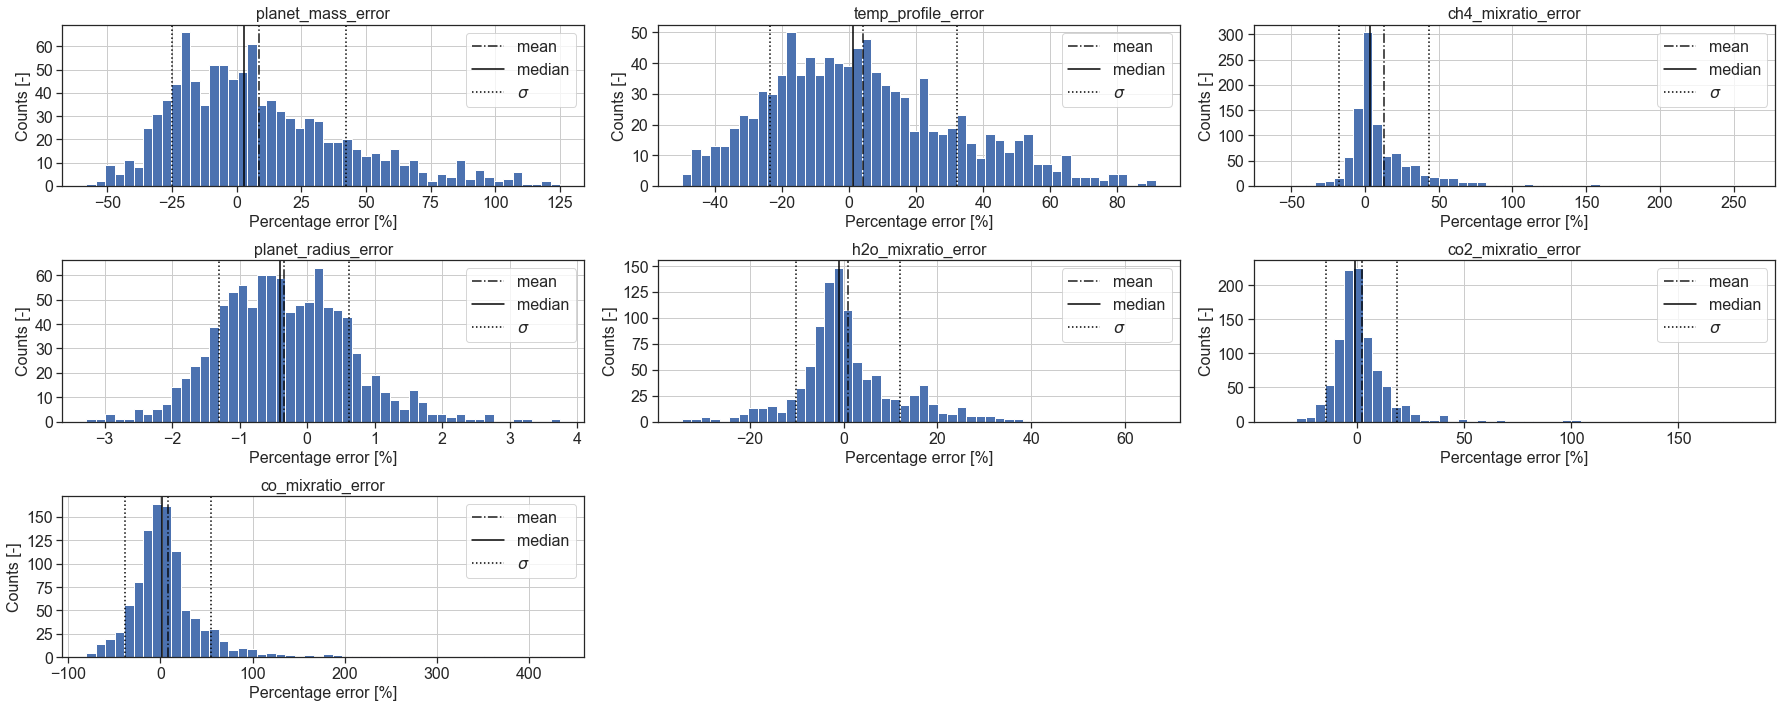

In [68]:
params = ['planet_mass','temp_profile','ch4_mixratio','planet_radius','h2o_mixratio','co2_mixratio','co_mixratio']
#params = ['planet_mass','ch4_mixratio','planet_radius','h2o_mixratio','co2_mixratio','co_mixratio']

fontsize = 16
plt.figure(figsize=((25,10)))
for i,param in enumerate(params):
    plt.subplot(3,3,i+1)
    plt.title(param+'_error', fontsize=fontsize)
    plt.hist(df[param+'_error'], bins=50)
    
    # plot mean and median line
    mu = df[param+'_error'].mean()
    plt.axvline(x=mu,  color='black', linestyle='-.', alpha=0.9, label='mean')
    plt.axvline(x=df[param+'_error'].median(),  color='black', linestyle='-', alpha=1, label='median')

    # plot std lines
    plt.axvline(x=mu-df[param+'_error'].std(),  color='black', linestyle=':', alpha=1, label=r'$\sigma$')
    plt.axvline(x=mu+df[param+'_error'].std(),  color='black', linestyle=':', alpha=1)
    
    plt.xticks(fontsize=fontsize)
    plt.yticks(fontsize=fontsize)
    
    plt.xlabel('Percentage error [%]', fontsize=fontsize)
    plt.ylabel('Counts [-]', fontsize=fontsize)
    
    plt.legend(fontsize=fontsize)
    plt.grid()
    plt.tight_layout()

# Grab the $n$ sigma errors

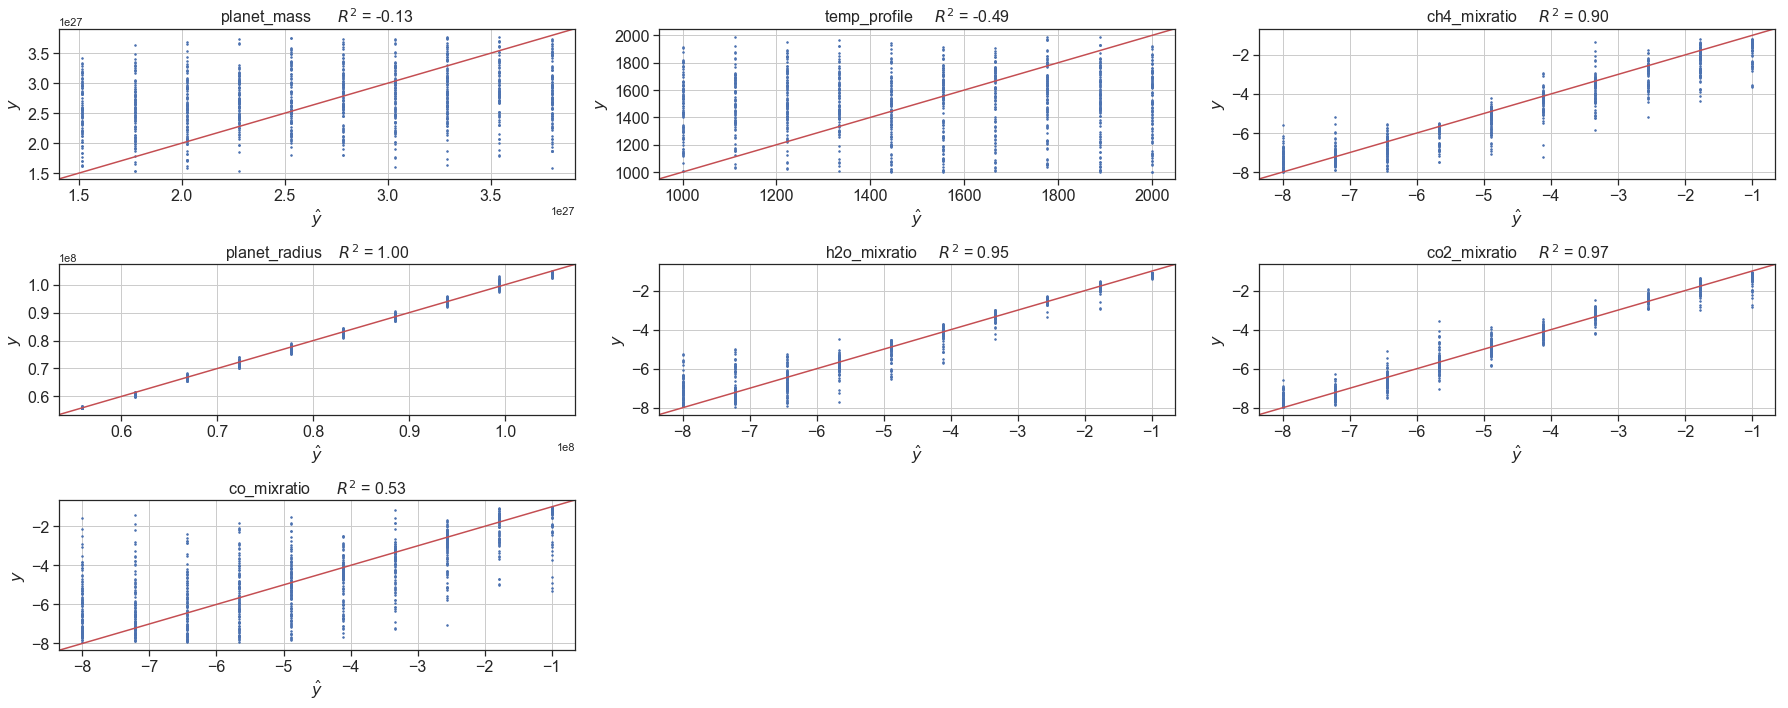

In [69]:
plt.figure(figsize=((25,10)))

for i,param in enumerate(params):
    y_hat = df[param+'_real']
    y = df[param+'_inpainted']
    
    r2 = r2_score(y_hat, y)
    
    plt.subplot(3,3,i+1)

    plt.title(param +' \t $R^2$ = %.2f' % r2, fontsize=fontsize)
    plt.plot(y_hat, y, '.', ms=3)
    
    """Force x,y range on the same scale outliers outside of range wont be plotted!"""
    x_min, x_max = plt.xlim()
    x_min = x_min*1
    x_max = x_max*1
    
    plt.ylim((x_min, x_max)) # set y axis range the same as x axis range
    plt.xlim((x_min, x_max))
    
    # Plot the red 'perfect' prediction line
    plt.plot(plt.xlim(), plt.ylim(), ls="-", c='r')
    
    plt.xticks(fontsize=fontsize)
    plt.yticks(fontsize=fontsize)
    
    plt.xlabel(r"$\hat{y}$", fontsize=fontsize)
    plt.ylabel(r"$y$", fontsize=fontsize)
    plt.grid()
    plt.tight_layout()

# 1$\sigma$ percentage error per parameter

### Unique values STD plot
y axis, STD  
X axis, unique values  

This plot shows the STD per parameter value (10 values for ExoGAN data)

Horizontal -. line is the 10% line

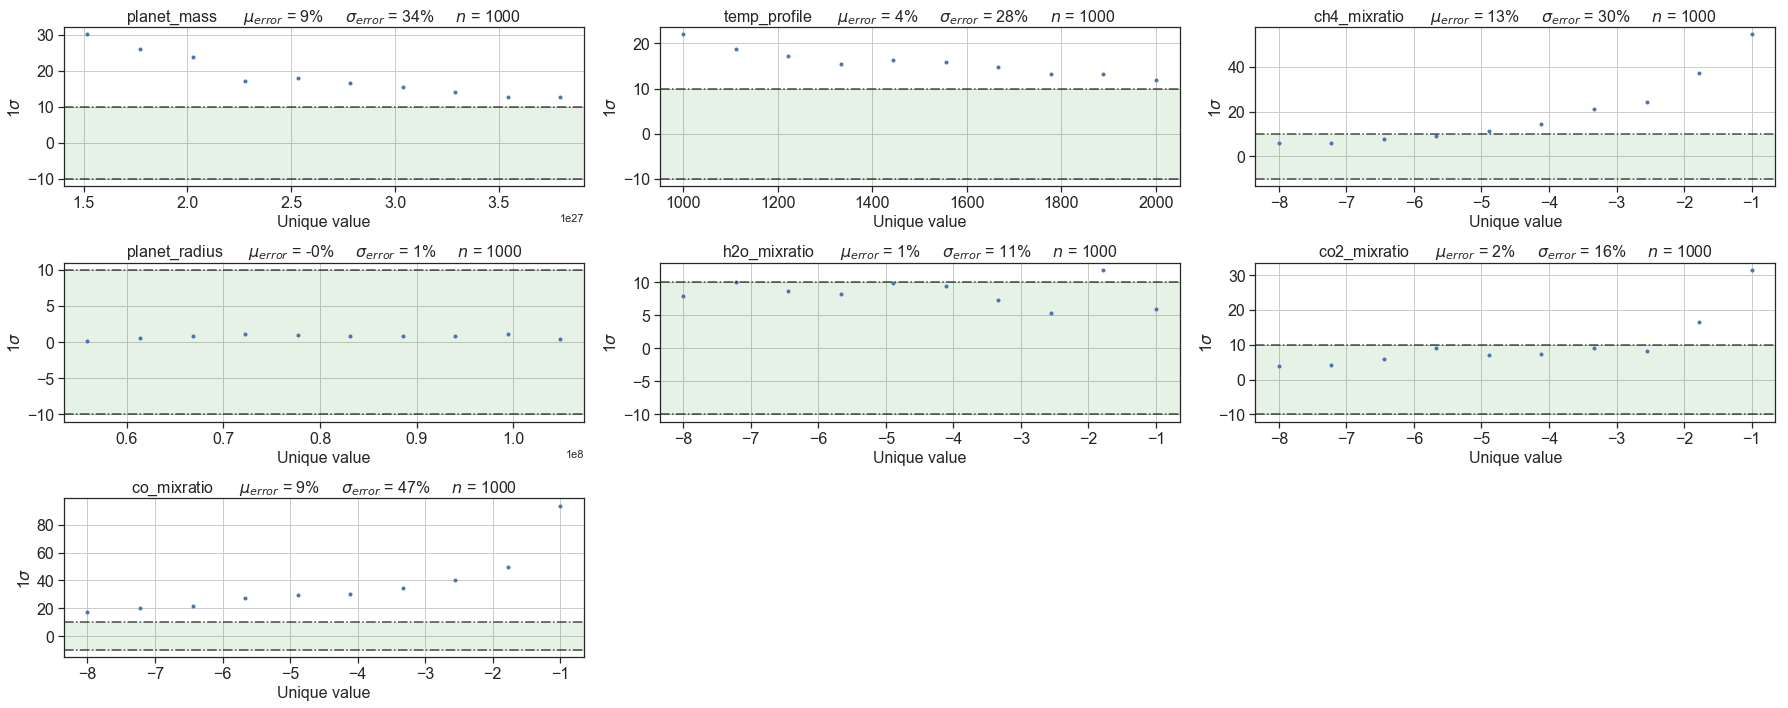

In [70]:
plt.figure(figsize=((25,10)))

for i,param in enumerate(params):
    uniques = df[param+'_real'].unique()
    
    counts = []
    stds = []
    for unique in uniques:
        t = df[param+'_error'][(df[param+'_real'] == unique)]
        std = t.std()
        count = t.count()
        #print(count, std)

        counts.append(count)
        stds.append(std)

    plt.subplot(3,3,i+1)
    plt.plot(uniques, stds, '.')
    
    plt.axhline(y=10,  color='black', linestyle='-.', alpha=0.7, label='10%')
    plt.axhline(y=-10,  color='black', linestyle='-.', alpha=0.7)
    plt.axhspan(10, -10, alpha=0.1, color='green')
    
    """layout"""""
    plt.xticks(fontsize=fontsize)
    plt.yticks(fontsize=fontsize)
    
    plt.grid()
    title_text = r'%s      $\mu_{error}$ = %.0f%%     $\sigma_{error}$ = %.0f%%     $n$ = %s' % (param, df[param+'_error'].mean(), df[param+'_error'].std(), len(df))
    plt.title(title_text, fontsize=fontsize)
    plt.xlabel('Unique value', fontsize=fontsize)
    plt.ylabel(r'1$\sigma$', fontsize=fontsize)
    plt.tight_layout()
    

In [71]:
iters = [np.load(iters) for iters in n_iterations]
iters

[array([1999, 1999, 1999, ..., 1999, 1999, 1999])]

In [72]:
uniques

array([-4.11111108, -7.22222227, -5.6666667 , -6.44444454, -1.77777773,
       -3.3333333 , -4.88888892, -2.55555546, -8.        , -1.        ])

# Losses

In [73]:
df[['perceptuals', 'contextuals']].describe()

,perceptuals,contextuals
count,1000.000000,1000.000000
mean,-0.087588,15.981021
std,0.022460,23.446495
min,-0.170745,5.574443
25%,-0.101668,9.600015
50%,-0.084612,11.216429
75%,-0.070866,13.284892
max,-0.029515,188.992401


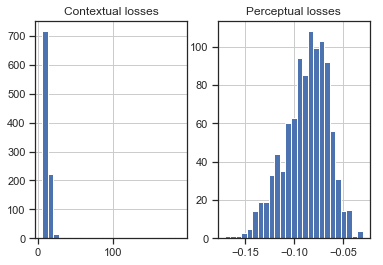

In [74]:
plt.subplot(1,2,1)
plt.hist(df.contextuals, bins=25)
plt.title('Contextual losses')
plt.grid()

plt.subplot(1,2,2)
plt.hist(df.perceptuals, bins=25)
plt.title('Perceptual losses')
plt.grid()

# Param percentage errors vs contextual loss
For contextual loss, lower is better.

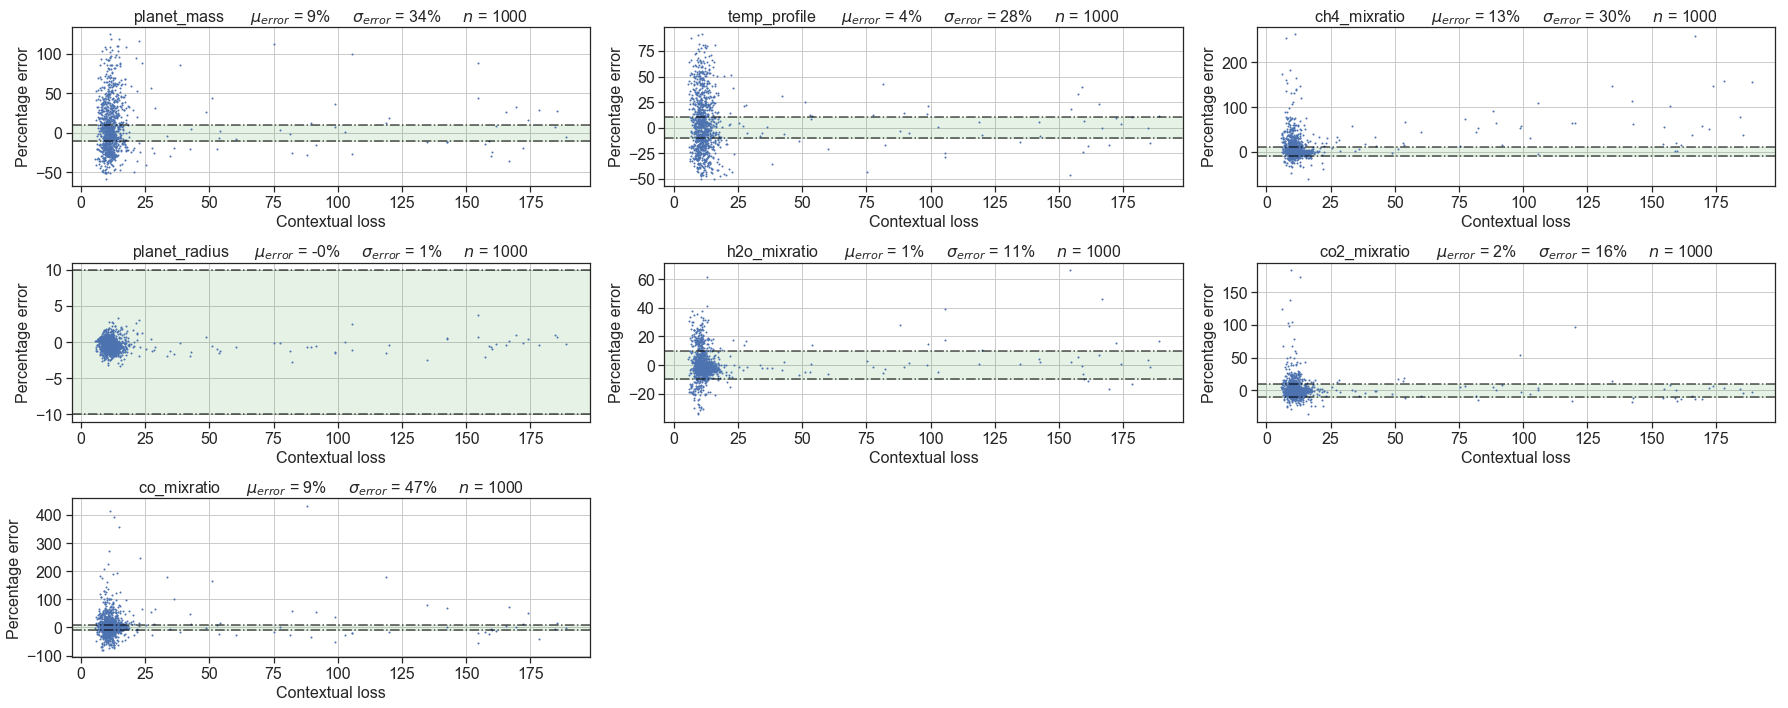

In [75]:
plt.figure(figsize=((25,10)))

for i,param in enumerate(params):
    plt.subplot(3,3,i+1)
    plt.plot(df.contextuals, df[param+'_error'], '.', ms=2)
    
    plt.axhline(y=10,  color='black', linestyle='-.', alpha=0.7, label='10%')
    plt.axhline(y=-10,  color='black', linestyle='-.', alpha=0.7)
    plt.axhspan(10, -10, alpha=0.1, color='green')
    
    """layout"""""
    plt.xticks(fontsize=fontsize)
    plt.yticks(fontsize=fontsize)
    
    #plt.ylim((-100,100))
    
    plt.grid()
    title_text = r'%s      $\mu_{error}$ = %.0f%%     $\sigma_{error}$ = %.0f%%     $n$ = %s' % (param, df[param+'_error'].mean(), df[param+'_error'].std(), len(df))
    plt.title(title_text, fontsize=fontsize)
    plt.xlabel('Contextual loss', fontsize=fontsize)
    plt.ylabel(r'Percentage error', fontsize=fontsize)
    #plt.legend()
    plt.tight_layout()
    

# Param percentage errors vs perceptual loss
For perceptual loss, lower is better.

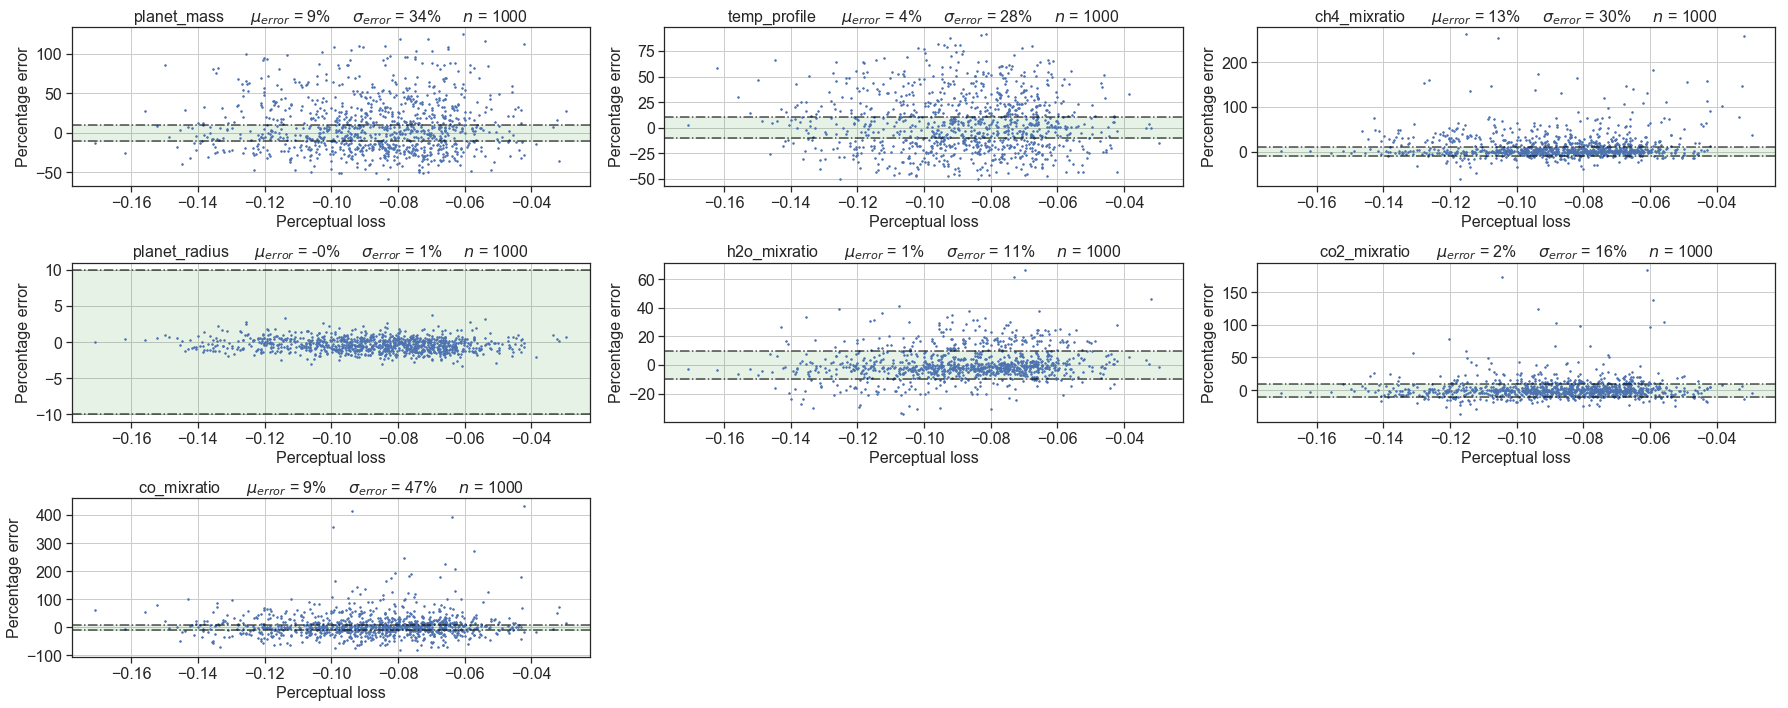

In [76]:
plt.figure(figsize=((25,10)))

for i,param in enumerate(params):
    plt.subplot(3,3,i+1)
    plt.plot(df.perceptuals, df[param+'_error'], '.', ms=3)
    
    plt.axhline(y=10,  color='black', linestyle='-.', alpha=0.7, label='10%')
    plt.axhline(y=-10,  color='black', linestyle='-.', alpha=0.7)
    plt.axhspan(10, -10, alpha=0.1, color='green')
    
    """layout"""""
    plt.xticks(fontsize=fontsize)
    plt.yticks(fontsize=fontsize)
    
    plt.grid()
    title_text = r'%s      $\mu_{error}$ = %.0f%%     $\sigma_{error}$ = %.0f%%     $n$ = %s' % (param, df[param+'_error'].mean(), df[param+'_error'].std(), len(df))
    plt.title(title_text, fontsize=fontsize)
    plt.xlabel('Perceptual loss', fontsize=fontsize)
    plt.ylabel(r'Percentage error', fontsize=fontsize)
    plt.tight_layout()